In [2]:
# Imports
import ast
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances, jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import spacy
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram
from gensim.models import Word2Vec, FastText
import numpy as np
from collections import defaultdict
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Melih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Melih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Melih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Main function + Load function
data = {}
titles = []

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

additionalStopWordsPreprocess = ['']
stopWordsPreprocess = stopwords.words('english') + additionalStopWordsPreprocess

filePaths = ["database_systems_publications.txt", "data_mining_publications.txt"]
filePath = filePaths[1]

def preProcessTitle(title, preProcessWay):
    '''
        Preprocess title in given way.
    '''
    title = title.lower()
    title = title.translate(str.maketrans('', '', string.punctuation))
    title = ' '.join(word for word in title.split() if word not in stopWordsPreprocess)

    if preProcessWay == 'lemmatization':
        title = ' '.join(lemmatizer.lemmatize(word) for word in title.split())
        return title
    elif preProcessWay == 'stemming':
        title = ' '.join(stemmer.stem(word) for word in title.split())
        return title
    else:
        return title

def preProcessData(preProcessWay):
    '''
        Preprocess data in a given way.
        Param: preProcessWay ["", "stemming", "lemmatization"]
    '''
    for year, titles_per_year in data.items():
        preProcessedTitles = [preProcessTitle(title, preProcessWay) for title in titles_per_year]
        data[year] = preProcessedTitles
        titles.extend(preProcessedTitles)

def readData():
    '''
        Reading data from text file.
    '''
    with open(filePath, 'r', encoding='utf-8') as file:
        for line in file:
            data_entry = ast.literal_eval(line)

            year = data_entry.get('year', '')
            title = data_entry.get('title', '')

            if year not in data:
                data[year] = []
            data[year].append(title)

def main():
    titles = []
    readData()
    preProcessWays = ['', 'stemming', 'lemmatization']
    preProcessData(preProcessWays[2])

main()

In [4]:
# Test Load Function
titles = []
def load():
    return [
    'Introduction to World Religions',
    'The Impact of Computer Science on Society',
    'Rocket Propulsion Technologies and Space Exploration',
    'Social Media Trends and Influencer Marketing',
    'Comparative Religious Studies',
    'Algorithms and Data Structures in Python',
    'How Rockets Work: A Beginner’s Guide',
    'The Role of Social Media in Political Movements',
    'Cultural Practices in Different Religions',
    'Artificial Intelligence and Machine Learning Applications',
    'SpaceX and the Future of Rocket Technology',
    'Privacy and Ethics in Social Media',
    'History of Religious Art and Architecture',
    'Cybersecurity Challenges in the Digital Age',
    'The Science Behind Rocket Launches',
    'Influence of Social Media on Consumer Behavior',
    'Religious Freedom and Human Rights',
    'Emerging Technologies: Blockchain and Cryptocurrency',
    'Building and Launching Small Rockets',
    'The Impact of Social Media on Mental Health',
    'Philosophical Perspectives on Religion',
    'Human-Computer Interaction and User Experience',
    'Satellites and Their Role in Modern Communication',
    'Fake News and Misinformation on Social Media',
]


In [5]:
# TfIdf with LDA

titles = load()
vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X = vectorizer.fit_transform(titles)

num_topics = 4  # You can adjust this based on your data

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-4 - 1:-1]])

# Assign Topics to Titles
topic_assignments = lda.transform(X).argmax(axis=1)

# Create a dictionary to store titles for each topic
topics_dict = {i: [] for i in range(num_topics)}

for i, title in enumerate(titles):
    topics_dict[topic_assignments[i]].append(title)
print()
# Print titles for each topic
for topic, titles in topics_dict.items():
    print(f"Topic #{topic + 1}:")
    print(titles)

Topic #1:
['media', 'social', 'trends', 'influencer']
Topic #2:
['perspectives', 'philosophical', 'religion', 'political']
Topic #3:
['religious', 'science', 'impact', 'launches']
Topic #4:
['media', 'social', 'world', 'introduction']

Topic #1:
['Rocket Propulsion Technologies and Space Exploration', 'Social Media Trends and Influencer Marketing', 'Artificial Intelligence and Machine Learning Applications', 'Fake News and Misinformation on Social Media']
Topic #2:
['The Role of Social Media in Political Movements', 'SpaceX and the Future of Rocket Technology', 'Philosophical Perspectives on Religion']
Topic #3:
['The Impact of Computer Science on Society', 'Comparative Religious Studies', 'How Rockets Work: A Beginner’s Guide', 'Cultural Practices in Different Religions', 'History of Religious Art and Architecture', 'Cybersecurity Challenges in the Digital Age', 'The Science Behind Rocket Launches', 'Religious Freedom and Human Rights', 'The Impact of Social Media on Mental Health']
T

In [6]:
# TF IDF VECTORIZER with and without Cosine + KMEANS

titles = load()
tfidf_vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X_tfidf = tfidf_vectorizer.fit_transform(titles)
# Set the number of clusters (topics)
num_clusters = 4  # Adjust as needed
cosine_sim_matrix = cosine_similarity(X_tfidf, X_tfidf)
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans.fit(cosine_sim_matrix)
# Assign cluster labels to titles
cluster_assignments = kmeans.labels_
# Create a dictionary to store titles for each cluster
clusters_dict = {i: [] for i in range(num_clusters)}

for i, title in enumerate(titles):
    clusters_dict[cluster_assignments[i]].append(title)

# Print titles for each cluster
for cluster, titles in clusters_dict.items():
    print(f"Cluster #{cluster + 1}:")
    print(titles)

print()
print()

titles = load()
tfidf_vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X_tfidf = tfidf_vectorizer.fit_transform(titles)
# Set the number of clusters (topics)
num_clusters = 4  # Adjust as needed
X_dense = X.toarray()
cosine = pairwise_distances(X_tfidf, metric='cosine')
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans.fit(cosine)
# Assign cluster labels to titles
cluster_assignments = kmeans.labels_
# Create a dictionary to store titles for each cluster
clusters_dict = {i: [] for i in range(num_clusters)}

for i, title in enumerate(titles):
    clusters_dict[cluster_assignments[i]].append(title)

# Print titles for each cluster
for cluster, titles in clusters_dict.items():
    print(f"Cluster #{cluster + 1}:")
    print(titles)

print()
print()
# TF IDF VECTORIZER + KMEANS
titles = load()
tfidf_vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X_tfidf = tfidf_vectorizer.fit_transform(titles)
# Set the number of clusters (topics)
num_clusters = 4  # Adjust as needed
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans.fit(X_tfidf)
# Assign cluster labels to titles
cluster_assignments = kmeans.labels_
# Create a dictionary to store titles for each cluster
clusters_dict = {i: [] for i in range(num_clusters)}

for i, title in enumerate(titles):
    clusters_dict[cluster_assignments[i]].append(title)

# Print titles for each cluster
for cluster, titles in clusters_dict.items():
    print(f"Cluster #{cluster + 1}:")
    print(titles)

Cluster #1:
['Introduction to World Religions', 'Cultural Practices in Different Religions']
Cluster #2:
['The Impact of Computer Science on Society', 'Rocket Propulsion Technologies and Space Exploration', 'SpaceX and the Future of Rocket Technology', 'The Science Behind Rocket Launches']
Cluster #3:
['Comparative Religious Studies', 'History of Religious Art and Architecture', 'Religious Freedom and Human Rights', 'Human-Computer Interaction and User Experience']
Cluster #4:
['Social Media Trends and Influencer Marketing', 'Algorithms and Data Structures in Python', 'How Rockets Work: A Beginner’s Guide', 'The Role of Social Media in Political Movements', 'Artificial Intelligence and Machine Learning Applications', 'Privacy and Ethics in Social Media', 'Cybersecurity Challenges in the Digital Age', 'Influence of Social Media on Consumer Behavior', 'Emerging Technologies: Blockchain and Cryptocurrency', 'Building and Launching Small Rockets', 'The Impact of Social Media on Mental Heal

c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


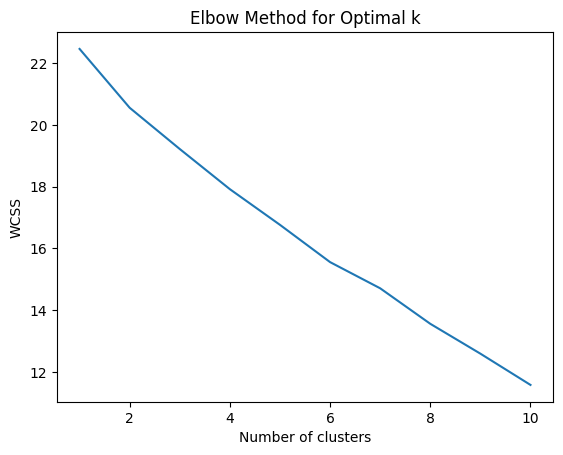

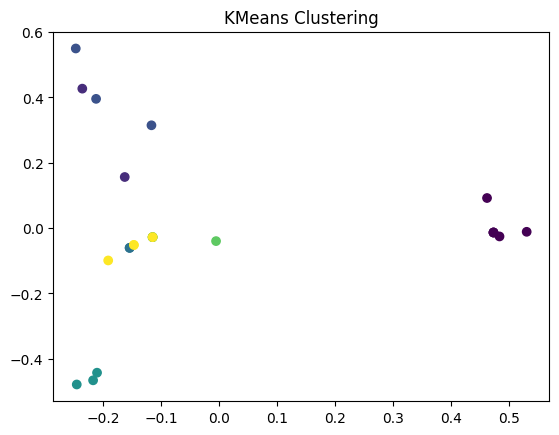

Cluster #1 Titles:
- Social Media Trends and Influencer Marketing
- The Role of Social Media in Political Movements
- Privacy and Ethics in Social Media
- Influence of Social Media on Consumer Behavior
- The Impact of Social Media on Mental Health
- Fake News and Misinformation on Social Media

Cluster #2 Titles:
- Rocket Propulsion Technologies and Space Exploration
- Emerging Technologies: Blockchain and Cryptocurrency

Cluster #3 Titles:
- The Impact of Computer Science on Society
- SpaceX and the Future of Rocket Technology
- The Science Behind Rocket Launches

Cluster #4 Titles:
- Introduction to World Religions
- Cultural Practices in Different Religions

Cluster #5 Titles:
- Comparative Religious Studies
- History of Religious Art and Architecture
- Religious Freedom and Human Rights

Cluster #6 Titles:
- Cybersecurity Challenges in the Digital Age

Cluster #7 Titles:
- Satellites and Their Role in Modern Communication

Cluster #8 Titles:
- Algorithms and Data Structures in Pyth

In [6]:


# Convert titles to TF-IDF features
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method to find the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

# Based on the plot, choose the optimal number of clusters (k)
k = 9  # Replace with your chosen number of clusters

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Visualize the clusters using PCA (for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans Clustering')
plt.show()
# Print titles for each cluster
for cluster_num in range(k):
    cluster_titles = [titles[i] for i, label in enumerate(kmeans.labels_) if label == cluster_num]
    print(f"Cluster #{cluster_num + 1} Titles:")
    for title in cluster_titles:
        print(f"- {title}")
    print()


In [10]:
# Linkage 
titles = load()
# Convert titles to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Calculate the linkage matrix
linkage_matrix = linkage(X.toarray(), method='ward', metric='euclidean')

# Plot the hierarchical clustering dendrogram
dendrogram(linkage_matrix, labels=titles, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


rocks : religi
corpora : religion
Cluster #1 Titles:
- Social Media Trends and Influencer Marketing
- The Role of Social Media in Political Movements
- Privacy and Ethics in Social Media
- Influence of Social Media on Consumer Behavior
- The Impact of Social Media on Mental Health
- Fake News and Misinformation on Social Media

Cluster #2 Titles:
- Comparative Religious Studies
- History of Religious Art and Architecture
- Religious Freedom and Human Rights

Cluster #3 Titles:
- Human-Computer Interaction and User Experience

Cluster #4 Titles:
- The Impact of Computer Science on Society
- The Science Behind Rocket Launches

Cluster #5 Titles:
- Rocket Propulsion Technologies and Space Exploration
- SpaceX and the Future of Rocket Technology
- Emerging Technologies: Blockchain and Cryptocurrency

Cluster #6 Titles:
- How Rockets Work: A Beginner’s Guide
- Building and Launching Small Rockets

Cluster #7 Titles:
- Introduction to World Religions
- Cultural Practices in Different Religio

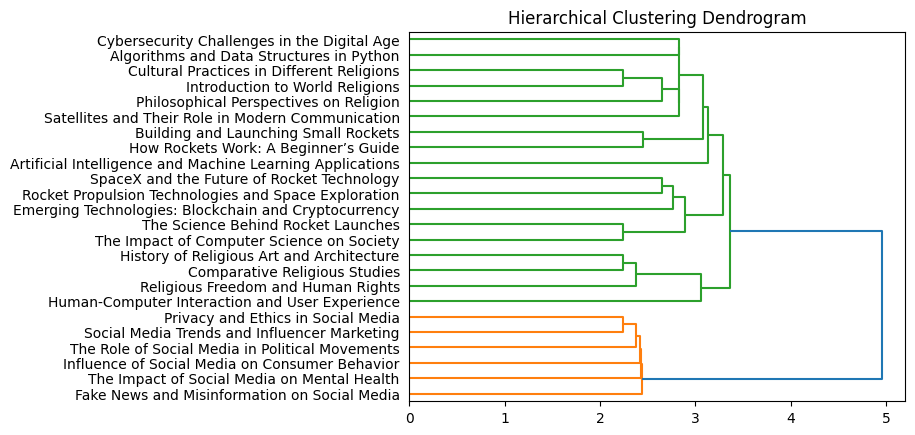

In [10]:
# F CLUSTERING (HIERACHISCH)
# Assuming you have a function load() that provides a list of titles
titles = load()
print("rocks :", stemmer.stem("religious"))
print("corpora :", stemmer.stem("religion"))
# Convert titles to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Calculate the linkage matrix
linkage_matrix = linkage(X.toarray(), method='ward', metric='euclidean')

# Choose the number of clusters (adjust this based on your preference)
num_clusters = 10

clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print titles for each cluster
for cluster_num in range(num_clusters):
    cluster_titles = [titles[i] for i, label in enumerate(clusters) if label == cluster_num + 1]
    print(f"Cluster #{cluster_num + 1} Titles:")
    for title in cluster_titles:
        print(f"- {title}")
    print()

# Plot the hierarchical clustering dendrogram
dendrogram(linkage_matrix, labels=titles, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

k = 5
# Assume titles is a list of document titles
print('TFIDF')
print()
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)


kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)


print("-------------------------------------------------")
print('TFIDF+ JACCARD')
print()
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

X_dense = X.toarray()
jaccard_similarity = pairwise_distances(X_dense, metric='jaccard')
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(jaccard_similarity)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)

print("-------------------------------------------------")
print('TFIDF+ COSINE')
print()
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

X_dense = X.toarray()
jaccard_similarity = pairwise_distances(X_dense, metric='cosine')
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(jaccard_similarity)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)


print("-------------------------------------------------")
print('COUNT')
print()
titles = load()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)


kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)

    

print("-------------------------------------------------")
print('COUNT + COSINE')
print()
titles = load()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

X_dense = X.toarray()
jaccard_similarity = pairwise_distances(X_dense, metric='cosine')

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(jaccard_similarity)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)

print("-------------------------------------------------")
print('COUNT + JACCARD')
print()
titles = load()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

X_dense = X.toarray()
jaccard_similarity = pairwise_distances(X_dense, metric='jaccard')

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(jaccard_similarity)
for cluster_num in range(k):
    cluster_indices = np.where(kmeans.labels_ == cluster_num)[0]
    similar_docs = [titles[i] for i in cluster_indices]
    print(f"Cluster #{cluster_num + 1} Similar Documents:")
    print(similar_docs)



TFIDF

Cluster #1 Similar Documents:
['A Deep Neural Network Approach for Image Recognition', 'Natural Language Processing with Recurrent Neural Networks', 'Machine Learning Applications in Healthcare', 'AI-Powered Robotics for Automation', 'AI Applications in Finance and Economics', 'Decoding the Neural Basis of Consciousness', 'Neuronal Mechanisms of Addiction', 'Brain-Computer Interfaces for Communication and Rehabilitation', 'Neurological Disorders and Their Treatments', 'The Formation and Evolution of Galaxies', 'Searching for Exoplanets in the Cosmos', 'The Mysteries of Dark Matter and Dark Energy', 'Understanding the Big Bang and the Origins of the Universe', 'Climate Change and Its Impacts on Ecosystems', 'Sustainability and Renewable Energy Solutions', 'Conservation Efforts for Endangered Species']
Cluster #2 Similar Documents:
['Unsupervised Learning Techniques for Data Clustering', 'Reinforcement Learning for Optimal Decision-Making', 'Exploring the Role of Brain Plasticity 

c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Melih\miniforge3\envs\bda2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availab

In [50]:


# Convert titles to TF-IDF features
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Choose the optimal number of clusters (k) based on the Elbow method or other criteria
k = 4  # Replace with your chosen number of clusters

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Get the most frequent words for each cluster
for cluster_num in range(k):
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == cluster_num]
    cluster_titles = [titles[i] for i in cluster_indices]
    cluster_X = X[cluster_indices]

    # Sum the TF-IDF values for each word across titles in the cluster
    word_frequencies = cluster_X.sum(axis=0)

    # Get the feature names and their corresponding frequencies
    feature_names = vectorizer.get_feature_names_out()
    cluster_word_freq = [(feature_names[i], word_frequencies[0, i]) for i in range(len(feature_names))]

    # Sort words by frequency and print the top words
    cluster_word_freq.sort(key=lambda x: x[1], reverse=True)
    top_words = [word for word, freq in cluster_word_freq[:10]]  # Adjust the number of top words as needed

    print(f"Cluster #{cluster_num + 1} Top Words:")
    print(top_words)
    print()


Cluster #1 Top Words:
['data', 'autonomous', 'challenges', 'cybersecurity', 'era', 'future', 'iot', 'transportation', 'vehicles', 'analysis']

Cluster #2 Top Words:
['learning', 'financial', 'forecasting', 'machine', 'advancements', 'deep', 'image', 'recognition', 'age', 'analysis']

Cluster #3 Top Words:
['artificial', 'healthcare', 'impact', 'intelligence', 'advancements', 'age', 'analysis', 'applications', 'autonomous', 'beginner']

Cluster #4 Top Words:
['guide', 'beginner', 'computing', 'quantum', 'understanding', 'comprehensive', 'language', 'natural', 'processing', 'python']



In [51]:
# Convert titles to CountVectorizer features
titles = load()
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Choose the optimal number of clusters (k) based on the Elbow method or other criteria
k = 4  # Replace with your chosen number of clusters

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Get the most frequent words for each cluster
for cluster_num in range(k):
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == cluster_num]
    cluster_titles = [titles[i] for i in cluster_indices]
    cluster_X = X[cluster_indices]

    # Sum the word counts for each word across titles in the cluster
    word_frequencies = cluster_X.sum(axis=0)

    # Get the feature names and their corresponding frequencies
    feature_names = vectorizer.get_feature_names_out()
    cluster_word_freq = [(feature_names[i], word_frequencies[0, i]) for i in range(len(feature_names))]

    # Sort words by frequency and print the top words
    cluster_word_freq.sort(key=lambda x: x[1], reverse=True)
    top_words = [word for word, freq in cluster_word_freq[:10]]  # Adjust the number of top words as needed

    print(f"Cluster #{cluster_num + 1} Top Words:")
    print(top_words)
    print()


Cluster #1 Top Words:
['guide', 'beginner', 'comprehensive', 'computing', 'language', 'natural', 'processing', 'python', 'quantum', 'understanding']

Cluster #2 Top Words:
['learning', 'advancements', 'analysis', 'artificial', 'autonomous', 'challenges', 'cybersecurity', 'deep', 'era', 'exploring']

Cluster #3 Top Words:
['data', 'age', 'big', 'ethics', 'privacy', 'advancements', 'analysis', 'applications', 'artificial', 'autonomous']

Cluster #4 Top Words:
['applications', 'blockchain', 'chain', 'management', 'supply', 'technology', 'advancements', 'age', 'analysis', 'artificial']



In [23]:

# Convert titles to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Calculate the linkage matrix
linkage_matrix = linkage(X.toarray(), method='ward')

# Determine the optimal number of clusters (you may need to adjust this based on the dendrogram)
num_clusters = 10  # Replace with your chosen number of clusters

# Use fcluster to assign each title to a cluster
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Get the most frequent words for each cluster
for cluster_num in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_num + 1]
    cluster_titles = [titles[i] for i in cluster_indices]
    cluster_X = X[cluster_indices]

    # Sum the TF-IDF values for each word across titles in the cluster
    word_frequencies = cluster_X.sum(axis=0)

    # Get the feature names and their corresponding frequencies
    feature_names = vectorizer.get_feature_names_out()
    cluster_word_freq = [(feature_names[i], word_frequencies[0, i]) for i in range(len(feature_names))]

    # Sort words by frequency and print the top words
    cluster_word_freq.sort(key=lambda x: x[1], reverse=True)
    top_words = [word for word, freq in cluster_word_freq[:10]]  # Adjust the number of top words as needed

    print(f"Cluster #{cluster_num + 1} Top Words:")
    print(top_words)
    print()


Cluster #1 Top Words:
['learning', 'financial', 'forecasting', 'machine', 'advancements', 'deep', 'image', 'recognition', 'age', 'analysis']

Cluster #2 Top Words:
['guide', 'beginner', 'computing', 'quantum', 'understanding', 'comprehensive', 'language', 'natural', 'processing', 'python']

Cluster #3 Top Words:
['artificial', 'healthcare', 'impact', 'intelligence', 'advancements', 'age', 'analysis', 'applications', 'autonomous', 'beginner']

Cluster #4 Top Words:
['data', 'age', 'big', 'ethics', 'privacy', 'advancements', 'analysis', 'applications', 'artificial', 'autonomous']

Cluster #5 Top Words:
['analysis', 'exploring', 'media', 'sentiment', 'social', 'techniques', 'advancements', 'age', 'applications', 'artificial']

Cluster #6 Top Words:
['autonomous', 'future', 'transportation', 'vehicles', 'advancements', 'age', 'analysis', 'applications', 'artificial', 'beginner']

Cluster #7 Top Words:
['challenges', 'cybersecurity', 'era', 'iot', 'advancements', 'age', 'analysis', 'applica

In [49]:

# Convert titles to TF-IDF features
vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X = vectorizer.fit_transform(titles)

# Set the number of topics (components)
num_topics = 10  # Adjust based on your data
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(X)

# Print top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])
    print()


Topic #1:
['forecasting', 'financial', 'machine', 'learning', 'future', 'exploring', 'ethics', 'era', 'deep', 'data']

Topic #2:
['computing', 'understanding', 'beginner', 'quantum', 'guide', 'forecasting', 'financial', 'exploring', 'ethics', 'era']

Topic #3:
['exploring', 'analysis', 'techniques', 'social', 'sentiment', 'media', 'learning', 'guide', 'comprehensive', 'ethics']

Topic #4:
['chain', 'management', 'technology', 'supply', 'applications', 'blockchain', 'financial', 'exploring', 'ethics', 'era']

Topic #5:
['healthcare', 'impact', 'intelligence', 'artificial', 'computing', 'financial', 'exploring', 'ethics', 'era', 'deep']

Topic #6:
['data', 'privacy', 'age', 'ethics', 'big', 'comprehensive', 'forecasting', 'financial', 'exploring', 'era']

Topic #7:
['iot', 'era', 'cybersecurity', 'challenges', 'vehicles', 'computing', 'forecasting', 'financial', 'exploring', 'ethics']

Topic #8:
['vehicles', 'autonomous', 'future', 'transportation', 'age', 'computing', 'forecasting', 'fi

In [48]:
"""
TFIDF + LDA
Deze is niet goed, zet vanalles in elke cluster. 
"""
titles = load()
# Convert titles to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Set the number of topics
num_topics = 10  # Replace with your chosen number of topics

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Print topics and associated words
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:7 - 1:-1]])
    print()


Topic #1:
['beginner', 'computing', 'quantum', 'understanding', 'guide', 'learning', 'age', 'big', 'ethics', 'privacy', 'healthcare', 'artificial', 'impact', 'intelligence', 'deep', 'image', 'advancements', 'recognition', 'vehicles', 'iot', 'transportation', 'autonomous', 'challenges', 'cybersecurity', 'era', 'future', 'data', 'chain', 'analysis', 'technology', 'media', 'techniques', 'supply', 'blockchain', 'exploring', 'applications', 'social', 'sentiment', 'management', 'natural']

Topic #2:
['learning', 'guide', 'privacy', 'age', 'big', 'ethics', 'healthcare', 'artificial', 'impact', 'intelligence', 'deep', 'image', 'advancements', 'recognition', 'era', 'challenges', 'cybersecurity', 'iot', 'transportation', 'autonomous', 'future', 'vehicles', 'data', 'supply', 'media', 'blockchain', 'chain', 'applications', 'technology', 'techniques', 'social', 'exploring', 'analysis', 'management', 'sentiment', 'language', 'comprehensive', 'processing', 'python', 'natural']

Topic #3:
['learning',

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Lemmatize the titles using spaCy
lemmatized_titles = []
titles = load()
titles = []
main()
for title in titles:
    doc = nlp(title)
    lemmatized_title = " ".join([token.lemma_ for token in doc])
    lemmatized_titles.append(lemmatized_title)


# Use TF-IDF vectorization with unigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range= (1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_titles)

# Apply K-means clustering
num_clusters = 9 # Adjust the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster assignments for each title
title_cluster_assignments = list(zip(titles, kmeans.labels_))

# Create a dictionary to store word frequencies for each cluster
cluster_word_frequencies = {i: {} for i in range(num_clusters)}

# Iterate over titles and update word frequencies for each cluster
for i, (title, cluster) in enumerate(title_cluster_assignments):
    doc = nlp(title)
    for token in doc:
        if token.lemma_ not in cluster_word_frequencies[cluster]:
            cluster_word_frequencies[cluster][token.lemma_] = 1
        else:
            cluster_word_frequencies[cluster][token.lemma_] += 1

# Print cluster information
for cluster, word_frequencies in cluster_word_frequencies.items():
    total_words = sum(word_frequencies.values())
    print(f"\nCluster #{cluster + 1} - Total Words: {total_words}")
    for word, frequency in word_frequencies.items():
        percentage = (frequency / total_words) * 100
        print(f"  - {word}: {percentage:.2f}%")
        
# Visualize most occurring words in each cluster using a bubble chart
for cluster, word_frequencies in cluster_word_frequencies.items():
    words = list(word_frequencies.keys())
    frequencies = np.array(list(word_frequencies.values()))
    total_words = frequencies.sum()

    # Calculate normalized sizes for the bubbles
    sizes = frequencies / total_words * 100

    # Scatter plot with bubble sizes
    plt.figure(figsize=(10, 6))
    plt.scatter(words, [1] * len(words), s=sizes * 100, alpha=0.5, cmap='viridis')

    # Set labels and title
    plt.title(f'Cluster #{cluster + 1} - Most Occurring Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency (%)')

    # Display word frequencies on top of the bubbles
    for i, word in enumerate(words):
        plt.text(
            word,
            1.1,
            f"{word} ({sizes[i]:.2f}%)",
            rotation=45,
            ha='center',
            va='center'
        )

    # Save or show the plot
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'cluster_{cluster + 1}_bubble_chart.png', bbox_inches='tight')
    plt.show()

{'data mining': 3465, 'neural network': 3366, 'time series': 3240, 'machine learning': 1737, 'social network': 1719, 'feature selection': 1620, 'data stream': 1521, 'reinforcement learning': 1494, 'graph neural': 1431, 'anomaly detection': 1368, 'association rule': 1332, 'deep learning': 1242, 'active learning': 1053, 'matrix factorization': 1035, 'recommender system': 1008, 'representation learning': 990, 'decision tree': 909, 'knowledge discovery': 873, 'support vector': 828, 'multitask learning': 819}


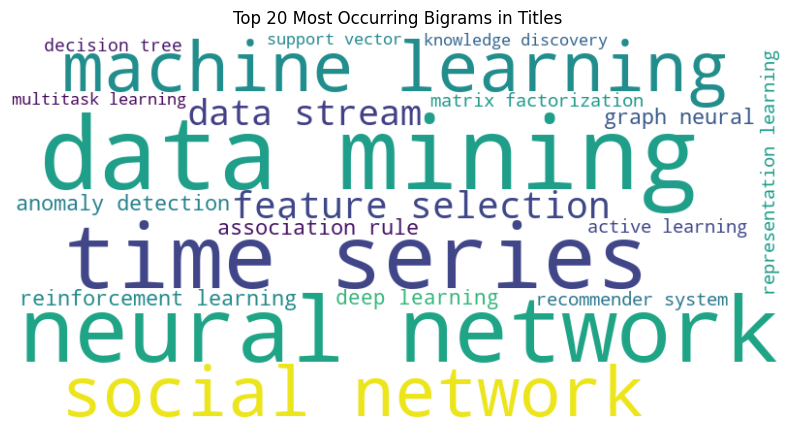

In [44]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a list of titles
titles = []
main()
# Combine all titles into a single string
text = ' '.join(titles)

# Tokenize the text into words
words = word_tokenize(text)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

# Create bigrams
bigrams = list(nltk.bigrams(filtered_words))

# Calculate the frequency of each bigram
bigram_freq = FreqDist(bigrams)

# Get the x most common bigrams
x_most_common = 20  # You can change this value to your desired number
top_bigrams = dict(bigram_freq.most_common(x_most_common))

# Convert bigram keys to strings
top_bigrams_str = {f"{bigram[0]} {bigram[1]}": count for bigram, count in top_bigrams.items()}
print(top_bigrams_str)
# Create a word cloud for the top bigrams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_bigrams_str)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Top {x_most_common} Most Occurring Bigrams in Titles')
plt.show()


{('graph', 'neural', 'network'): 2601, ('support', 'vector', 'machine'): 1190, ('multivariate', 'time', 'series'): 884, ('nonnegative', 'matrix', 'factorization'): 697, ('heterogeneous', 'information', 'network'): 680, ('deep', 'reinforcement', 'learning'): 612, ('convolutional', 'neural', 'network'): 612, ('time', 'series', 'classification'): 595, ('graph', 'convolutional', 'network'): 578, ('time', 'series', 'data'): 544, ('generative', 'adversarial', 'network'): 544, ('association', 'rule', 'mining'): 544, ('recurrent', 'neural', 'network'): 510, ('deep', 'neural', 'network'): 476, ('electronic', 'health', 'record'): 425, ('graph', 'representation', 'learning'): 425, ('time', 'series', 'forecasting'): 408, ('unsupervised', 'feature', 'selection'): 374, ('heterogeneous', 'graph', 'neural'): 340, ('dynamic', 'time', 'warping'): 340}


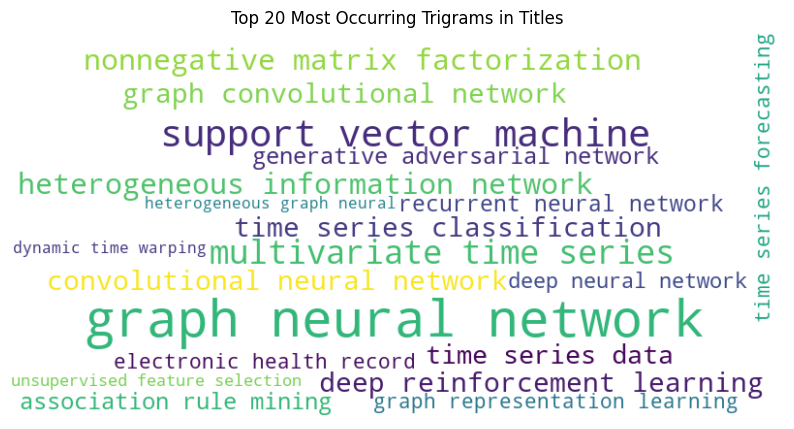

In [52]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a list of titles
titles = []
main()
# Combine all titles into a single string
text = ' '.join(titles)

# Tokenize the text into words
words = word_tokenize(text)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

# Create trigrams
trigrams = list(nltk.ngrams(filtered_words, 3))

# Calculate the frequency of each trigram
trigram_freq = FreqDist(trigrams)

# Get the x most common trigrams
x_most_common = 20  # You can change this value to your desired number
top_trigrams = dict(trigram_freq.most_common(x_most_common))
print(top_trigrams)
# Convert trigram keys to strings
top_trigrams_str = {' '.join(trigram): count for trigram, count in top_trigrams.items()}

# Create a word cloud for the top trigrams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_trigrams_str)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Top {x_most_common} Most Occurring Trigrams in Titles')
plt.show()


In [ ]:
# TF IDF + COSINE

import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a list of titles
titles = []
main()
# Combine all titles into a single string
text = ' '.join(titles)

# Tokenize the text into words
words = word_tokenize(text)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

# Create trigrams
trigrams = list(nltk.ngrams(filtered_words, 3))

# Calculate the frequency of each trigram
trigram_freq = FreqDist(trigrams)
# Convert trigram keys to strings
MOST_N_TOPICS = 45
print(trigram_freq.most_common()[:MOST_N_TOPICS])
top_trigrams_str = [' '.join(trigram) for trigram, count in trigram_freq.most_common()[:MOST_N_TOPICS]]
print(top_trigrams_str)
# Create a TF-IDF matrix for clustering
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(top_trigrams_str)
cosine = pairwise_distances(tfidf_matrix, metric='cosine')
# Perform K-means clustering
num_clusters = 3  # You can adjust this based on the number of topics you want to identify
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(cosine)
clusters = kmeans.labels_

# Print out the most occurring words in each cluster
for cluster_id in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_id]
    cluster_trigrams = [top_trigrams_str[i] for i in cluster_indices]

    # Print the most occurring words in the cluster
    print(f"Cluster {cluster_id + 1}:")
    for trigram in cluster_trigrams:
        print(f"- {trigram}")

    # Generate a word cloud for the cluster
    cluster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_trigrams))

    # Display the word cloud for each cluster
    # plt.figure(figsize=(10, 6))
    # plt.imshow(cluster_wordcloud, interpolation='bilinear')
    # plt.axis('off')
    # plt.title(f'Word Cloud for Cluster {cluster_id + 1}')
    # plt.show()


In [21]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
def analyze_clusters(clustered_titles):
    # Iterate through each cluster
    for cluster_id, titles_in_cluster in clustered_titles.items():
        # Combine titles in the cluster into a single string
        cluster_text = ' '.join(titles_in_cluster)

        # Tokenize the text into words
        words = word_tokenize(cluster_text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

        # Create trigrams
        trigrams = list(nltk.ngrams(filtered_words, 3))

        # Calculate the frequency of each trigram
        trigram_freq = nltk.FreqDist(trigrams)

        # Print the most occurring trigrams in the cluster
        MOST_N_TOPICS = 20
        print(f"Cluster {cluster_id + 1} - Most Common Trigrams:")
        print(f"Count of titles in cluster: {len(titles_in_cluster)}")
        print(titles_in_cluster)
        for trigram, count in trigram_freq.most_common(MOST_N_TOPICS):
            print(f"- {' '.join(trigram)}: {count}")

        # top_trigrams = dict(trigram_freq.most_common(MOST_N_TOPICS))
        # top_trigrams_str = {' '.join(trigram): count for trigram, count in top_trigrams.items()}

        # # Create a word cloud for the top trigrams
        # wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_trigrams_str)
        # plt.figure(figsize=(10, 6))
        # plt.imshow(wordcloud, interpolation='bilinear')
        # plt.axis('off')
        # plt.title(f'Top {MOST_N_TOPICS} Most Occurring Trigrams in Titles')
        # plt.show()

titles.clear()
main()
print(f"Count of titles in corpus: {len(titles)}")
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

# Perform K-means clustering
num_clusters = 20  # You can adjust this based on the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans.fit(tfidf_matrix)
clusters = kmeans.labels_

# Organize titles into clusters
clustered_titles = defaultdict(list)

print()
for i, label in enumerate(clusters):
    clustered_titles[label].append(titles[i])

# Analyze trigrams within each cluster
analyze_clusters(clustered_titles)

Count of titles in corpus: 115880

Cluster 7 - Most Common Trigrams:
Count of titles in cluster: 2048
['feature selection montecarlo search growing single rooted directed acyclic graph best leaf identification', 'agnostic feature selection', 'stability feature selection presence feature correlation', 'link prediction via higherorder motif feature', 'interpretable discriminative dimensionality reduction feature selection manifold', 'unsupervised qualitative scoring binary item feature', 'joint feature selection selfrepresentation learning robust multiview subspace clustering', 'adaptive unsupervised feature selection attributed network', 'seasonaladjustment based feature selection method predicting epidemic largescale search engine log', 'feature selection montecarlo search growing single rooted directed acyclic graph best leaf identification', 'agnostic feature selection', 'stability feature selection presence feature correlation', 'link prediction via higherorder motif feature', 'inte

In [16]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict


# Assuming 'titles' is a list of publication titles
# Set the number of clusters
num_clusters = 3
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

# Perform MiniBatch K-Means clustering
minibatch_kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
clusters = minibatch_kmeans.fit_predict(tfidf_matrix)
# Perform MiniBatch K-Means clustering
# Organize titles into clusters
clustered_titles = defaultdict(list)
for i, label in enumerate(clusters):
    clustered_titles[label].append(titles[i])

# Analyze trigrams within each cluster (similar to your DBSCAN example)
analyze_clusters(clustered_titles)

TypeError: analyze_clusters() missing 1 required positional argument: 'vectorizer'

In [11]:
# DBSCAN
from sklearn.cluster import DBSCAN

# Assuming 'titles' is a list of publication titles
titles = load()
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

n_features = len(vectorizer.get_feature_names_out())
print(f"Number of features (unique terms): {n_features}")
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust parameters
clusters = dbscan.fit_predict(tfidf_matrix)

# Organize titles into clusters
clustered_titles = defaultdict(list)
print(f"Count of titles in corpus: {len(titles)}")
print()

for i, label in enumerate(clusters):
    clustered_titles[label].append(titles[i])

# Analyze trigrams within each cluster
analyze_clusters(clustered_titles)


Number of features (unique terms): 78
Count of titles in corpus: 24

Cluster 0 - Most Common Trigrams:
Count of titles in cluster: 24
['Introduction to World Religions', 'The Impact of Computer Science on Society', 'Rocket Propulsion Technologies and Space Exploration', 'Social Media Trends and Influencer Marketing', 'Comparative Religious Studies', 'Algorithms and Data Structures in Python', 'How Rockets Work: A Beginner’s Guide', 'The Role of Social Media in Political Movements', 'Cultural Practices in Different Religions', 'Artificial Intelligence and Machine Learning Applications', 'SpaceX and the Future of Rocket Technology', 'Privacy and Ethics in Social Media', 'History of Religious Art and Architecture', 'Cybersecurity Challenges in the Digital Age', 'The Science Behind Rocket Launches', 'Influence of Social Media on Consumer Behavior', 'Religious Freedom and Human Rights', 'Emerging Technologies: Blockchain and Cryptocurrency', 'Building and Launching Small Rockets', 'The Impa

In [15]:
# Agglomerative crasht
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# Assuming 'titles' is a list of publication titles
titles = load()  # Replace this with your data loading function
main()
# Vectorize titles using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)  # You may need to adjust parameters
clusters = agg_clustering.fit_predict(tfidf_matrix.toarray())  # Convert to array if necessary

# Organize titles into clusters
clustered_titles = defaultdict(list)
print(f"Count of titles in corpus: {len(titles)}")
print()

for i, label in enumerate(clusters):
    clustered_titles[label].append(titles[i])

# Analyze trigrams within each cluster (similar to your DBSCAN example)
analyze_clusters(clustered_titles)


: 

In [14]:
# BIRCH (BIRCH does not scale very well to high dimensional data. As a rule of thumb if n_features is greater than twenty, it is generally better to use MiniBatchKMeans.)
from sklearn.cluster import Birch


# Assuming 'titles' is a list of publication titles
titles = load()  # Replace this with your data loading function

# Vectorize titles using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)

# Perform BIRCH clustering
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=4)  # You may need to adjust parameters
clusters = birch.fit_predict(tfidf_matrix)

# Organize titles into clusters
clustered_titles = defaultdict(list)
print(f"Count of titles in corpus: {len(titles)}")
print()

for i, label in enumerate(clusters):
    clustered_titles[label].append(titles[i])

# Analyze trigrams within each cluster (similar to your DBSCAN example)
analyze_clusters(clustered_titles)


Count of titles in corpus: 24

Cluster 1 - Most Common Trigrams:
Count of titles in cluster: 9
['Introduction to World Religions', 'Algorithms and Data Structures in Python', 'How Rockets Work: A Beginner’s Guide', 'Cultural Practices in Different Religions', 'Artificial Intelligence and Machine Learning Applications', 'Cybersecurity Challenges in the Digital Age', 'Building and Launching Small Rockets', 'Philosophical Perspectives on Religion', 'Satellites and Their Role in Modern Communication']
Cluster 2 - Most Common Trigrams:
Count of titles in cluster: 6
['The Impact of Computer Science on Society', 'Rocket Propulsion Technologies and Space Exploration', 'SpaceX and the Future of Rocket Technology', 'The Science Behind Rocket Launches', 'Emerging Technologies: Blockchain and Cryptocurrency', 'Human-Computer Interaction and User Experience']
Cluster 4 - Most Common Trigrams:
Count of titles in cluster: 6
['Social Media Trends and Influencer Marketing', 'The Role of Social Media in

In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

def cluster_and_analyzef(titles, ngram_range=(1, 1)):
    # Create a TF-IDF matrix for clustering
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(titles)

    # Perform MiniBatch K-Means clustering
    num_clusters = 3  # You can adjust this based on the number of clusters you want
    minibatch_kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
    clusters = minibatch_kmeans.fit_predict(tfidf_matrix)

    # Organize titles into clusters
    clustered_titles = defaultdict(list)
    for i, label in enumerate(clusters):
        clustered_titles[label].append(titles[i])

    # Analyze features within each cluster
    analyze_clusters(clustered_titles, vectorizer)

def analyze_clusters(clustered_titles, vectorizer):
    for cluster_id, titles_in_cluster in clustered_titles.items():
        # Transform cluster titles to TF-IDF matrix
        cluster_tfidf_matrix = vectorizer.transform(titles_in_cluster)

        # Get feature names (words or n-grams)
        feature_names = vectorizer.get_feature_names_out()
        print(feature_names)
        # Get the most important features in the cluster
        cluster_features = [feature_names[i] for i in cluster_tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:20]]

        # Print the most important features in the cluster
        print(f"Cluster {cluster_id + 1} - Most Important Features:")
        print(len(cluster_features))
        for feature in cluster_features:
            print(f"- {feature}")
        print()

# Cluster and analyze with different ngram_range values
cluster_and_analyzef(titles, ngram_range=(1, 1))  # Unigrams
print()
print()
cluster_and_analyzef(titles, ngram_range=(1, 2))  # Unigrams and Bigrams
#cluster_and_analyze(titles, ngram_range=(1, 3))  # Unigrams, Bigrams, and Trigrams


['01' '05' '0bit' ... 'ℓ1' 'ℓ1regularized' 'ℓdiversity']
Cluster 3 - Most Important Features:
1
- [['learning' 'data' 'network' ... 'sumofsquared' 'classified'
  'outlierrobust']]

['01' '05' '0bit' ... 'ℓ1' 'ℓ1regularized' 'ℓdiversity']
Cluster 2 - Most Important Features:
1
- [['clustering' 'data' 'spectral' ... 'overlabeling' 'overhead' '01']]

['01' '05' '0bit' ... 'ℓ1' 'ℓ1regularized' 'ℓdiversity']
Cluster 1 - Most Important Features:
1
- [['processbased' 'indicator' 'early' ... 'performancebased'
  'performanceadaptive' '01']]



['01' '01 data' '05' ... 'ℓ1regularized learning' 'ℓ1regularized logistic'
 'ℓdiversity']
Cluster 3 - Most Important Features:
1
- [['learning' 'data' 'network' ... 'distilling bert' 'progression model'
  'costaware early']]

['01' '01 data' '05' ... 'ℓ1regularized learning' 'ℓ1regularized logistic'
 'ℓdiversity']
Cluster 1 - Most Important Features:
1
- [['time series' 'series' 'time' ... 'output kernel' 'output industrial'
  '01']]

['01' '01 data' '05